In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

from utils import *
from algorithm import *

In [2]:
print(np.__version__)
print(pd.__version__)
print(sklearn.__version__)
print(mpl.__version__)
print(scipy.__version__)

1.26.4
2.2.1
1.4.2
3.8.4
1.13.1


In [3]:
RACES = {" White": 0, " Black": 1, " Asian-Pac-Islander": 2, " Amer-Indian-Eskimo": 3, " Other": 4}
RACES_inverse = {0: " White", 1: " Black",  2:" Asian-Pac-Islander", 3: " Amer-Indian-Eskimo", 4: " Other"}

def get_features(data_fn):
    data = np.loadtxt(data_fn, dtype='str', delimiter=',')

    df = pd.DataFrame(data)

    df = df.replace(' ?',np.nan)
    df.dropna(how='any',inplace=True)
    
    try:
        y = df.iloc[:,-1].map({' <=50K':0,' >50K':1}).astype(int).values
    except ValueError:
        y = df.iloc[:,-1].map({' <=50K.':0,' >50K.':1}).astype(int).values
    
    df = df.drop(df.columns[-1], axis=1) 

    df.iloc[:,-1] = df.iloc[:,-1].apply(lambda x: 1 if x == " United-States" else 0)
    df.iloc[:,-3] = df.iloc[:,-1].apply(lambda x: 0 if x == " 0" else 1)
    df.iloc[:,-4] = df.iloc[:,-1].apply(lambda x: 0 if x == " 0" else 1)

    cols = [1, 3, 5, 6, 7, 9]
    for col in cols:
        df[col] = pd.Categorical(df[col], categories=df[col].unique()).codes
    
    print(df.iloc[:,8].value_counts())
    df.iloc[:,8] = df.iloc[:,8].map(RACES)
    print(df.iloc[:,8].value_counts())

    grp = df.iloc[:,8].astype(int).values
    
    df = df.drop(df.columns[[2, 8]], axis=1) 
    X = df.astype(float).values

    #print(X.shape, y.shape)
    return (X, y, grp)

In [29]:
def run_lin_reg(X_tr, y_tr):
    Xinv = np.linalg.pinv(X_tr)
    c = Xinv.dot(y_tr)
    
    tr = np.trace(Xinv.dot(Xinv.T))
    #print('       ', tr)

    return c, tr

In [6]:
data = np.loadtxt('adult/adult.data', dtype='str', delimiter=',')
df = pd.DataFrame(data)
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,73,9,21648,16,16,7,15,6,5,2,119,92,94,42,2
top,36,Private,164190,HS-grad,9,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K
freq,898,22696,13,10501,10501,14976,4140,13193,27816,21790,29849,31042,15217,29170,24720


In [31]:
X_train, y_train, grp_train = get_features('adult/adult.data')
races = RACES.values()

8
White                 25933
Black                  2817
Asian-Pac-Islander      895
Amer-Indian-Eskimo      286
Other                   231
Name: count, dtype: int64
8
0    25933
1     2817
2      895
3      286
4      231
Name: count, dtype: int64


0  White
(25933, 12) (25933,)


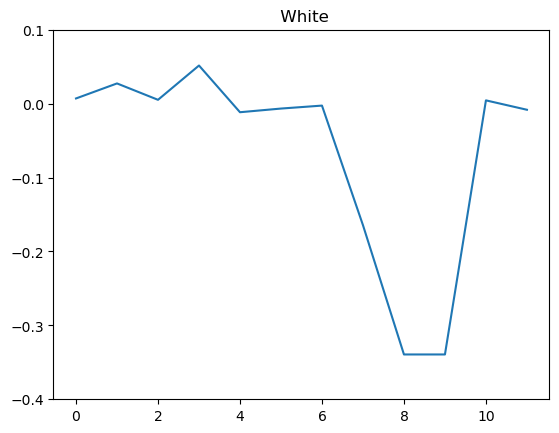


1  Black
(2817, 12) (2817,)


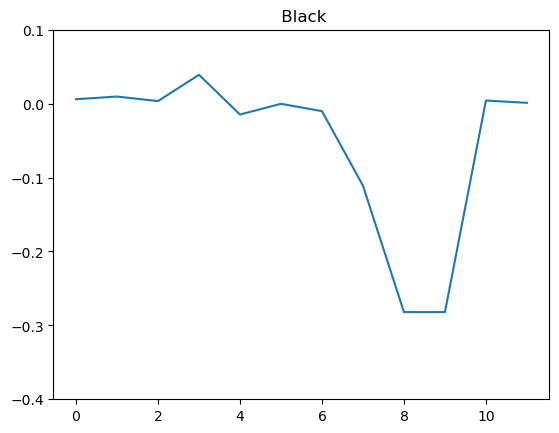


2  Asian-Pac-Islander
(895, 12) (895,)


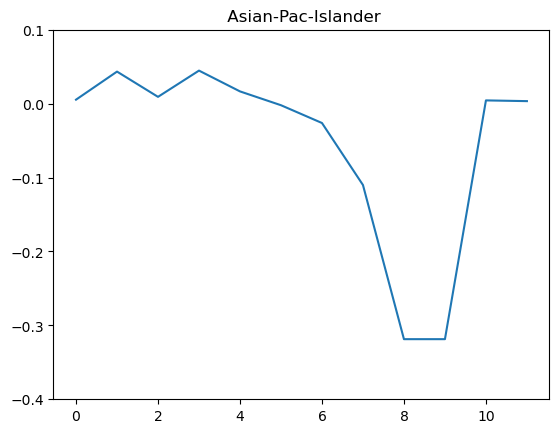


3  Amer-Indian-Eskimo
(286, 12) (286,)


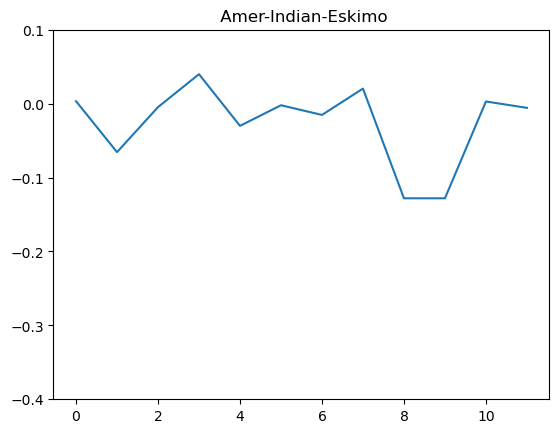


4  Other
(231, 12) (231,)


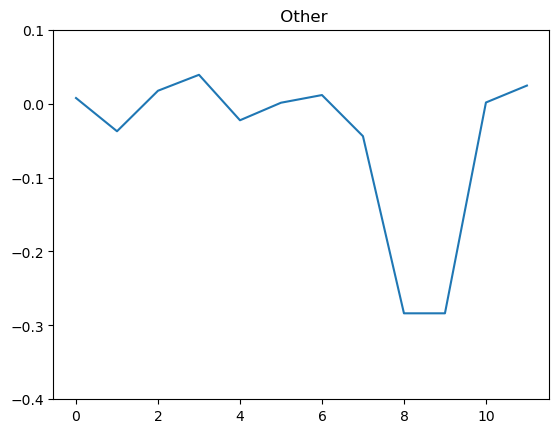


(5, 12)


In [32]:
var_squared = []
betas = []

for race in races:
    print(race, RACES_inverse[race])
    
    X_small, y_small = X_train[grp_train==race, :], y_train[grp_train==race]
    print(X_small.shape, y_small.shape)
    
    c, tr = run_lin_reg(X_small, y_small)

    betas.append(c)
    
    plt.plot(c)
    plt.gca().set_ylim([-0.4,0.1])
    plt.title(RACES_inverse[race])
    plt.show()
    
    m = X_small.shape[0]
    r = sum((y_small - X_small.dot(c))**2)
    var_squared.append(r/m*tr)
    print()

betas = np.array(betas)
print(betas.shape)

In [51]:
num_iter = 10
n = betas.shape[0]
d = betas.shape[1]

# OLS. iterative fusion, update W and bs_hat
new_est = betas
W_hats = []
for ii in range(num_iter):
    W_hat = get_weights(new_est, new_est, var_squared)
    new_est = W_hat.dot(new_est)
    W_hats.append(W_hat)

In [52]:
(W_hats[-1].T - W_hats[-1]).sum(axis=1)

array([ 2.23256588, -0.38819644, -0.80401062, -0.31816392, -0.72219489])

In [53]:
X_test, y_test, grp_test = get_features('adult/adult.test')
print(X_test.shape, y_test.shape)

8
White                 12970
Black                  1411
Asian-Pac-Islander      408
Amer-Indian-Eskimo      149
Other                   122
Name: count, dtype: int64
8
0    12970
1     1411
2      408
3      149
4      122
Name: count, dtype: int64
(15060, 12) (15060,)


In [57]:
y_test[grp_test==race]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [54]:
# %%
new_est = betas
for W in W_hats:
    new_est = W.dot(new_est)

auc_results = np.zeros((2, len(races)))

for ii, race in enumerate(races):
    print(race, RACES_inverse[race])
    print( )
    auc_results[0, ii] = roc_auc_score(y_test[grp_test==race], X_test[grp_test==race, :].dot(betas[ii, :]))
    auc_results[1, ii] = roc_auc_score(y_test[grp_test==race], X_test[grp_test==race, :].dot(new_est[ii, :]))
    
    print('before fusion:', np.round(auc_results[0, ii], 4))
    print('after fusion:', np.round(auc_results[1, ii], 4))
    print( )

0  White

before fusion: 0.8003
after fusion: 0.8012

1  Black

before fusion: 0.8322
after fusion: 0.8233

2  Asian-Pac-Islander

before fusion: 0.7846
after fusion: 0.7825

3  Amer-Indian-Eskimo

before fusion: 0.6704
after fusion: 0.7773

4  Other

before fusion: 0.7802
after fusion: 0.8384



for comparison, if we fit whole dataset without splitting by race
0.8057745408260374


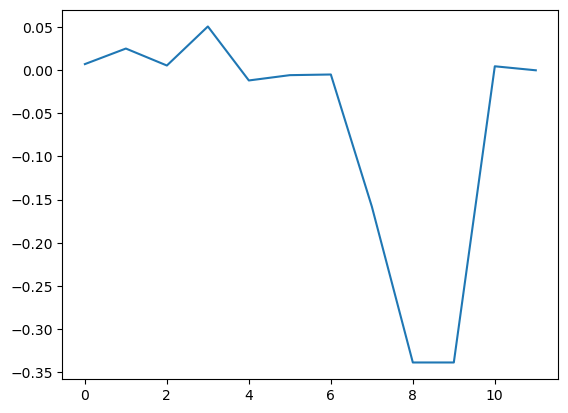

In [36]:
# # %% if we fit whole dataset, without splitting by race
print('for comparison, if we fit whole dataset without splitting by race')
coef, tr = run_lin_reg(X_train, y_train)
print(roc_auc_score(y_test, X_test.dot(coef)))
plt.plot(coef)
plt.show()

for comparison, if we fit whole dataset with race as a feature
0.8060981276170537


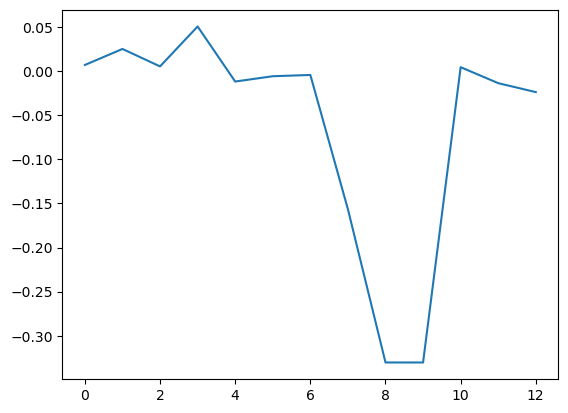

In [37]:
# %% if race was added as a feature
print('for comparison, if we fit whole dataset with race as a feature')
coef, tr = run_lin_reg(np.concatenate((X_train, grp_train.reshape(-1, 1)), axis=1), y_train)
print(roc_auc_score(y_test, np.concatenate((X_test, grp_test.reshape(-1,1)), axis=1).dot(coef)))
plt.plot(coef)
plt.show()

for comparison, if we fit whole dataset with race as a feature
(30162, 5) (15060, 5)
0.8070211386562619


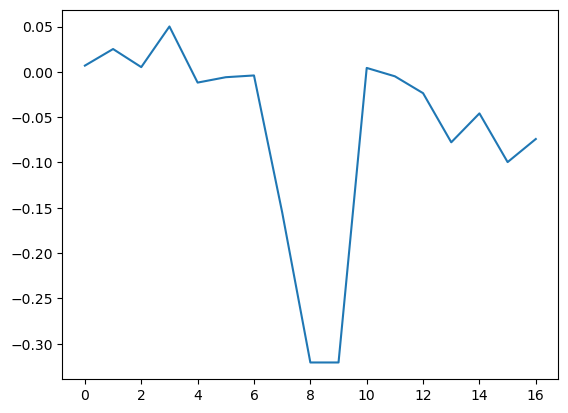

In [38]:
# %% race as dummy variable
print('for comparison, if we fit whole dataset with race as a feature')
train_dummy, test_dummy = [], []
for race in races:
    train_dummy.append(1.0*(grp_train == race))
    test_dummy.append(1.0*(grp_test == race))

train_dummy, test_dummy = np.array(train_dummy).T, np.array(test_dummy).T
print(train_dummy.shape, test_dummy.shape)
coef, tr = run_lin_reg(np.concatenate((X_train, train_dummy), axis=1), y_train)
print(roc_auc_score(y_test, np.concatenate((X_test, test_dummy), axis=1).dot(coef)))
plt.plot(coef)
plt.show()